# Working with Satellite Remote Sensing Data: Ocean Edition
## Focus on ENSO and Marine Heat Waves
### EDS 220 Fall 2021

This week's class will focus on some commonly employed diagnostics used in physical oceanography and climate science, using satellite remote sensing products. 

During the course of this lab exercise, we will cover the following topics/analysis skills:
- Use of OpeNDAP and THREDDS to access data remotely
- Spatial subsetting and regional averaging of data
- Removal of seasonal cycle using "groupby"
- Use of threshold exceedances to identify events (El Nino/La Nina, marine heat waves)
- Creating georeferenced maps of spatial fields using cartopy
- "Pickling" and "unpickling" variables for later use
- Building probability distribution functions

Many of the marine heat wave diagnostics in Part II are adapted from the "marineHeatWave" package developed by Eric Oliver for the Hobday et al. (2016) publication (see References) and available on Github:
https://github.com/ecjoliver/marineHeatWaves

#### **Datasets: ERSSTv5 and OISSTv2**
In this lab, we'll be using data from two sources:

- MONTHLY data from the Extended Reconstructed Sea Surface Temperature dataset version 5 (ERSSTv5), to identify El Nino and La Nina periods:
- DAILY data from NOAA's 1/4° Daily Optimum Interpolation Sea Surface Temperature (OISST) version 2, or OISSTv2, to identify marine heat waves. 


#### **OpeNDAP and THREDDS**

The method of accessing these files will be via the NOAA Open-source Project for a Network Data Access Protocol (OpeNDAP) server. OpeNDAP is a fairly common method of providing remote access to large data files without the need to download the entire file; more information can be found here:

https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap

https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap/opendap-user-guide

The OpeNDAP protocol is implemented on many scientific servers using a Web service called the Thematic Real-time Environmental Distributed Data Services (THREDDS), which is responsible for reading in the various metadata fields associated with the appropriate files. More information on THREDDS can be found here:

https://www.unidata.ucar.edu/software/tds/current/

### STEP ZERO: CONFIGURE ENVIRONMENT

The Python packages we will need for this and subsequent parts of the notebook are numpy, matplotlib, cartopy, scipy, pickle, and xarray:

In [302]:
# Configure environment
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.stats as stats
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import pickle

### PART 1: ENSO

First, we will apply the ERSSTv5 product to identify El Nino and La Nina events. 

The ERSSTv5 data is stored in a single file, containing information for the entire period. The website describing ERSSTv5 data can be found here:

https://psl.noaa.gov/thredds/catalog/Datasets/noaa.ersst.v5/catalog.html?dataset=Datasets/noaa.ersst.v5/sst.mnmean.nc

In [2]:
# location of ERSSTv5 data
ersst_url="https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"

In [3]:
# open dataset using remote URL
ersst=xr.open_dataset(ersst_url,drop_variables="time_bnds")

# display dataset to see what it looks like
ersst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2014)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-10-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2021-11-06
    DODS_EXTRA.Unlimited_Dimension:  time

Now we can subset this data to extract only information in the NINO3.4 region: 5S-5N, 190-240E (the middle of the Pacific):
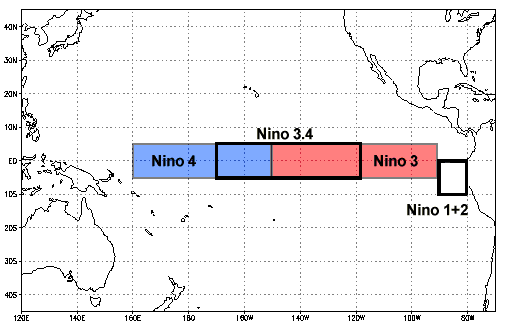

This regional filter will be constructed using _logical masking_: assigning "True" to values within a specified lat/lon range, and "False" to values outside that range. This approach to filtering is nice because it works regardless of the shape or regularity of your data's lat/lon spacing!

In [4]:
# Create logical masks for lat and lon variables
mask_lon = (ersst.lon >= 190) & (ersst.lon <= 240)
mask_lat = (ersst.lat >= -5) & (ersst.lat <= 5)

# Apply lat/lon masks to the ERSST field, then calculate averages over the lat and lon dimensions
n34_ts=ersst.where(mask_lon & mask_lat).mean("lon").mean("lat")

Let's make a plot to see what this time series looks like!

Text(0, 0.5, 'SST (C)')

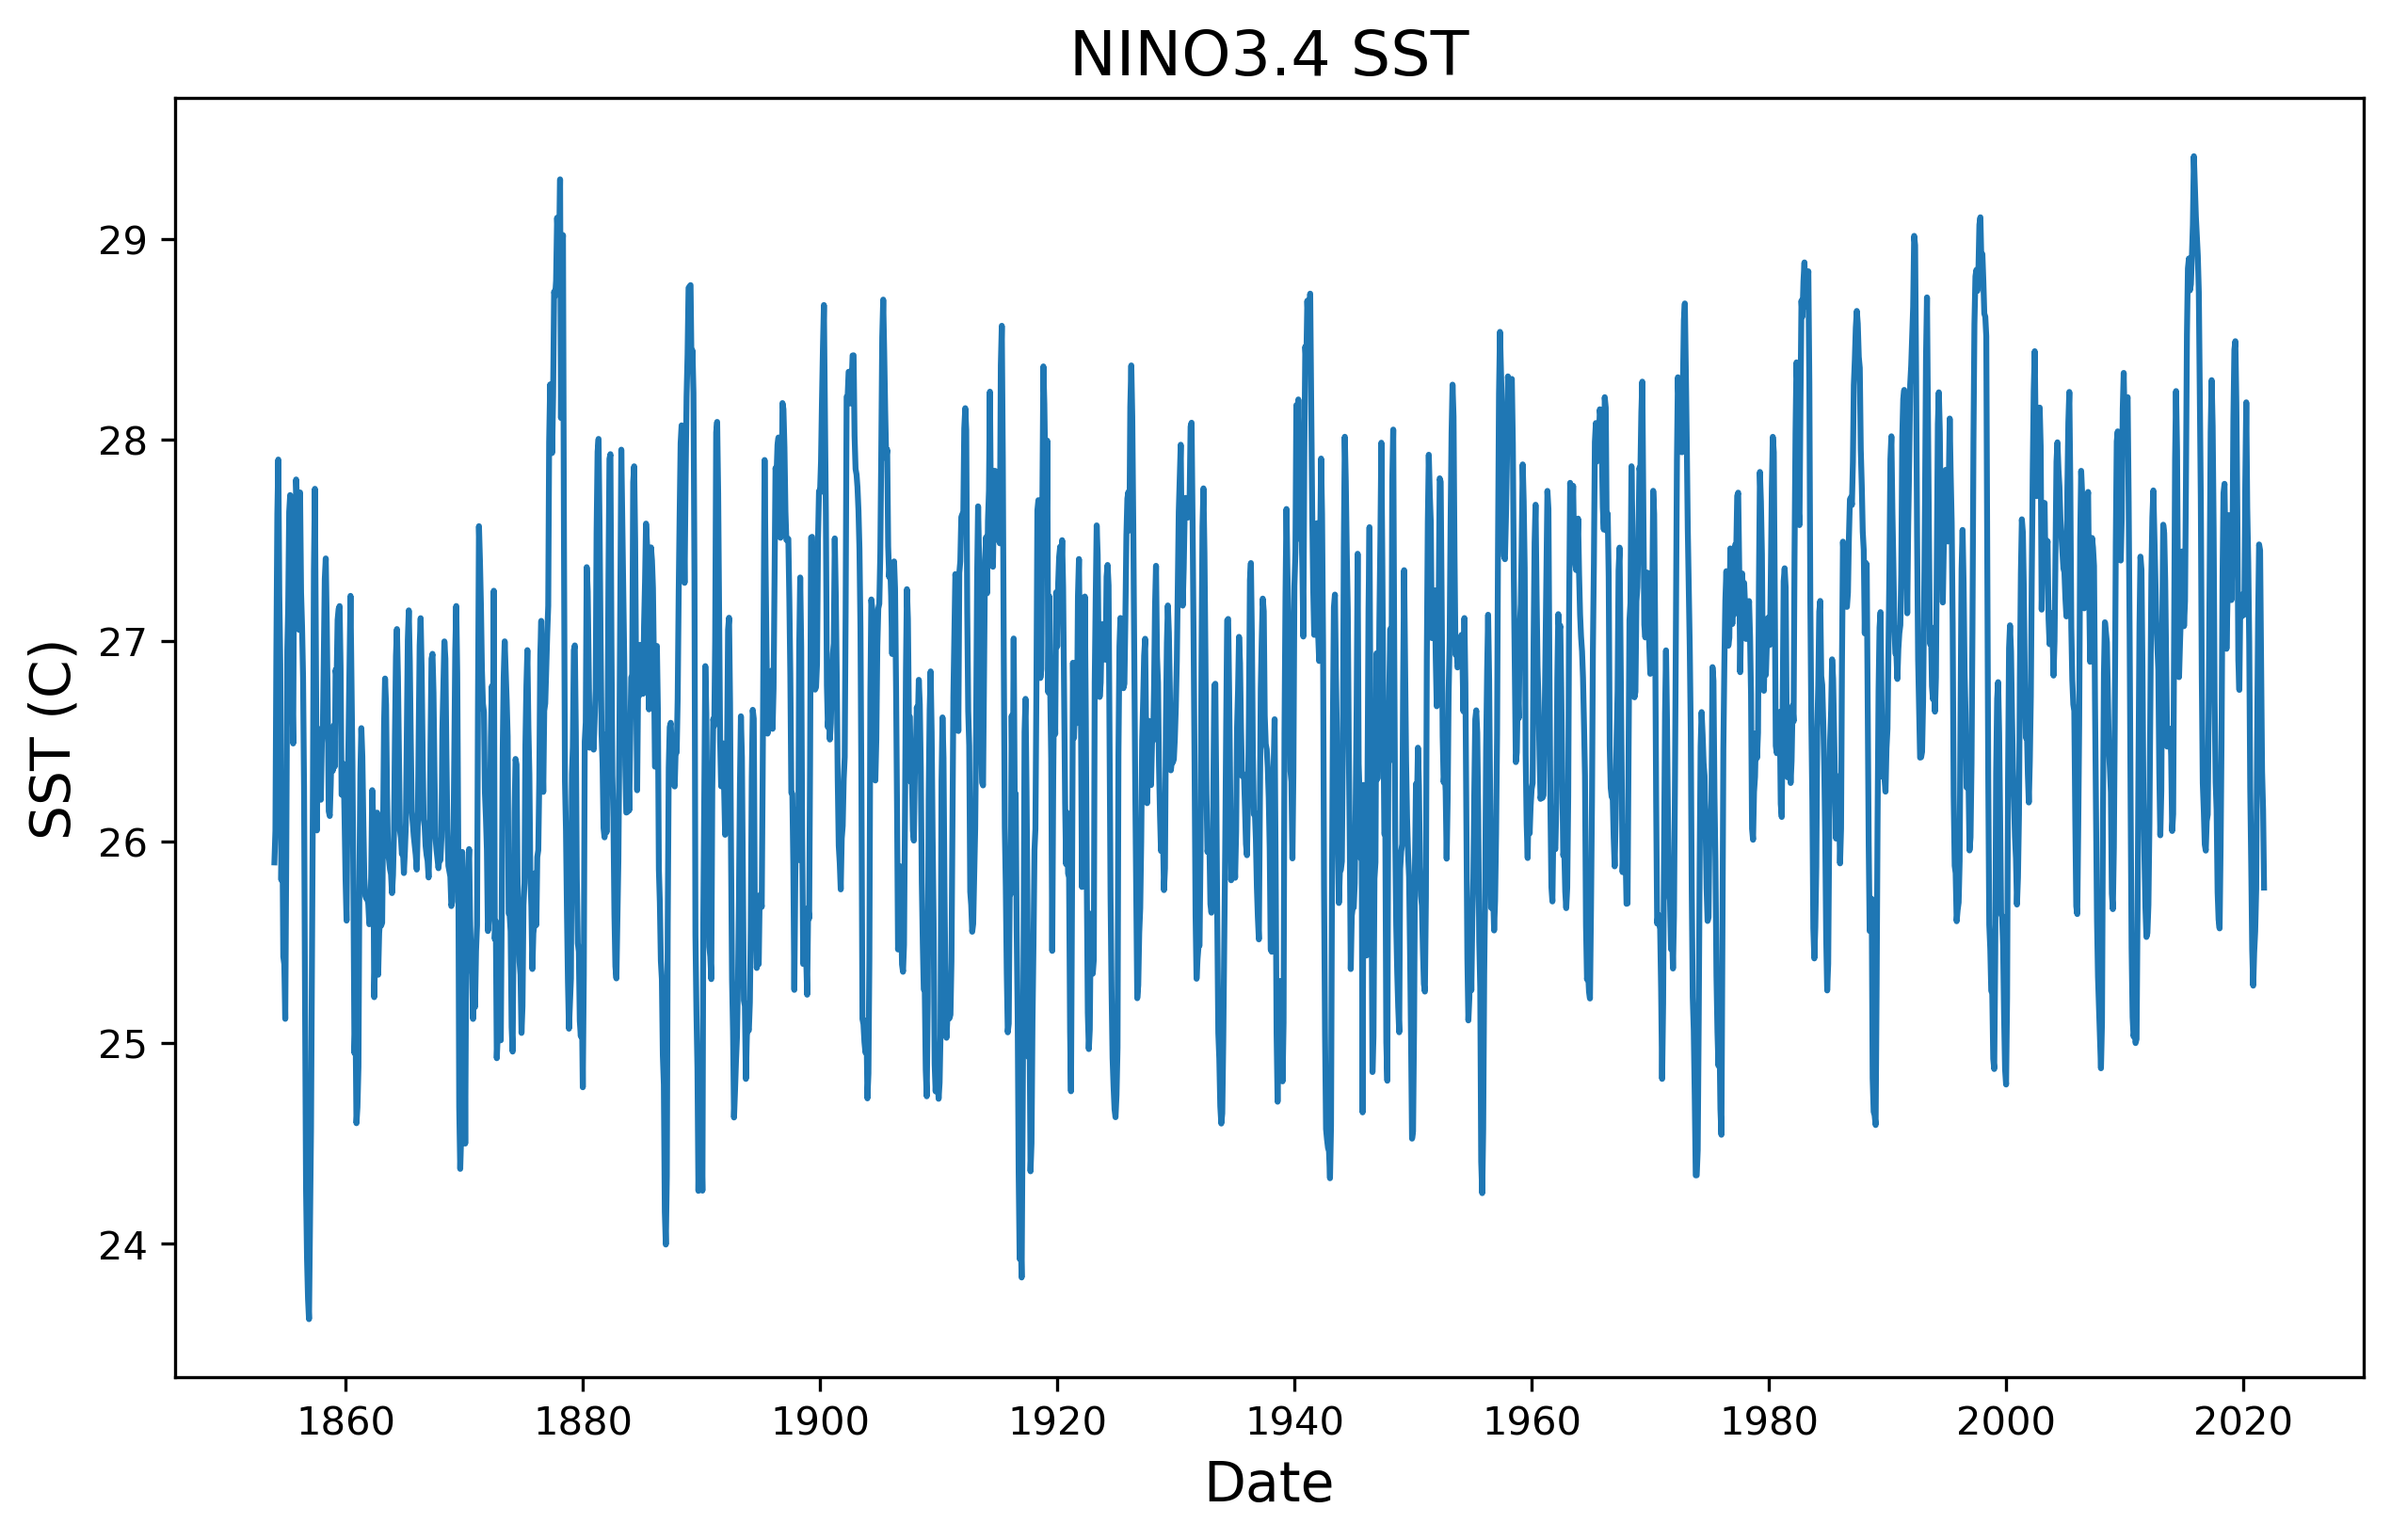

In [5]:
# create a new figure, set size and resolution (dpi)
plt.figure(figsize=(10, 6), dpi=300)    
# add data to the plot
plt.plot(n34_ts.time,n34_ts.sst)   
# Specify plot parameters
plt.title('NINO3.4 SST', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('SST (C)', fontsize=14)

There is clearly a lot of variability in the time series above, with some years warmer than others: but how do we decide what is really warmer than what would be expected? To do this, we need to remove the effects of seasonal changes in temperature. This is often done by computing the NINO3.4 "SST anomaly", where the mean value for each calendar month is removed (so for January, the average of all Januaries, for February the average of all Februaries, and so on). 

In xarray, the "groupby" functionality allows us to do this quite easily! We can get some basic information on groupby using the `?` syntax:

In [6]:
# Take a look at the groupby method in n34_ts
n34_ts.groupby?

Signature:
n34_ts.groupby(
    group,
    squeeze: 'bool' = True,
    restore_coord_dims: 'bool' = None,
)
Docstring:
Returns a GroupBy object for performing grouped operations.

Parameters
----------
group : str, DataArray or IndexVariable
    Array whose unique values should be used to group this array. If a
    string, must be the name of a variable contained in this dataset.
squeeze : bool, optional
    If "group" is a dimension of any arrays in this dataset, `squeeze`
    controls whether the subarrays have a dimension of length 1 along
    that dimension or if the dimension is squeezed out.
restore_coord_dims : bool, optional
    If True, also restore the dimension order of multi-dimensional
    coordinates.

Returns
-------
grouped
    A `GroupBy` object patterned after `pandas.GroupBy` that can be
    iterated over in the form of `(unique_value, grouped_array)` pairs.

Examples
--------
Calculate daily anomalies for daily data:

>>> da = xr.DataArray(
...     np.linspace(0, 182

We need to pass an argument to groupby, to tell it what to use to construct the groups. There are two possible syntaxes for this: the first uses a feature within xarray called the `DateTimeAccessor`, or .dt for short. This is applied to the time variable within the xarray dataframe:

In [7]:
# Display n34_ts DateTimeAccessor
n34_ts.time.dt

The DateTimeAccessor knows various things about the time that you can query: for instance, the calendar month:

In [8]:
# Query calendar month
n34_ts.time.dt.month

<xarray.DataArray 'month' (time: 2014)>
array([ 1,  2,  3, ...,  8,  9, 10])
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-10-01

Or when variables are already included in the dataframe, you can use a simpler syntax:

In [9]:
# Query calendar month more simply
n34_ts.groupby('time.month')

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

The above returned what's called a `GroupBy` object, which is essentially a list of groups and which parts of the dataset belong to which group. we can then calculate the monthly mean using this set of groups. Here I will also use the `sel` functionality to select a time period over which to calculate the climatology: 1971-2000 is the "base period" used in the NOAA operational definition of El Nino (more on that below).

Stacking up all our commands, we get:

In [10]:
# Select the 1971-2000 base period, group it by month, and compute a time average for each month
n34_ts.sel(time=slice('1971-01-01','2000-12-31')).groupby('time.month').mean("time")

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 26.46 26.66 27.14 27.58 ... 26.59 26.54 26.5 26.47

In order to complete our calculation, we next have to _apply_ the GroupBy object to the raw NINO3.4 time series.

The most efficient way (that I know of) to do this is to use the Python "function stacking" capabilities to simultaneously create the groupings and apply them, in a single line of code:

In [11]:
# Create the base period climatology and remove it from the NINO3.4 SST time series
n34_ssta = n34_ts.groupby("time.month") - n34_ts.sel(time=slice('1971-01-01','2000-12-31')).groupby("time.month").mean("time")

# Display SSTA dataset
n34_ssta

<xarray.Dataset>
Dimensions:  (time: 2014)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-10-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 12 1 2 3 4 5 6 7 8 9 10
Data variables:
    sst      (time) float32 -0.5593 -0.6085 -0.2285 ... -0.3064 -0.432 -0.7651

Text(0, 0.5, 'SSTA (C)')

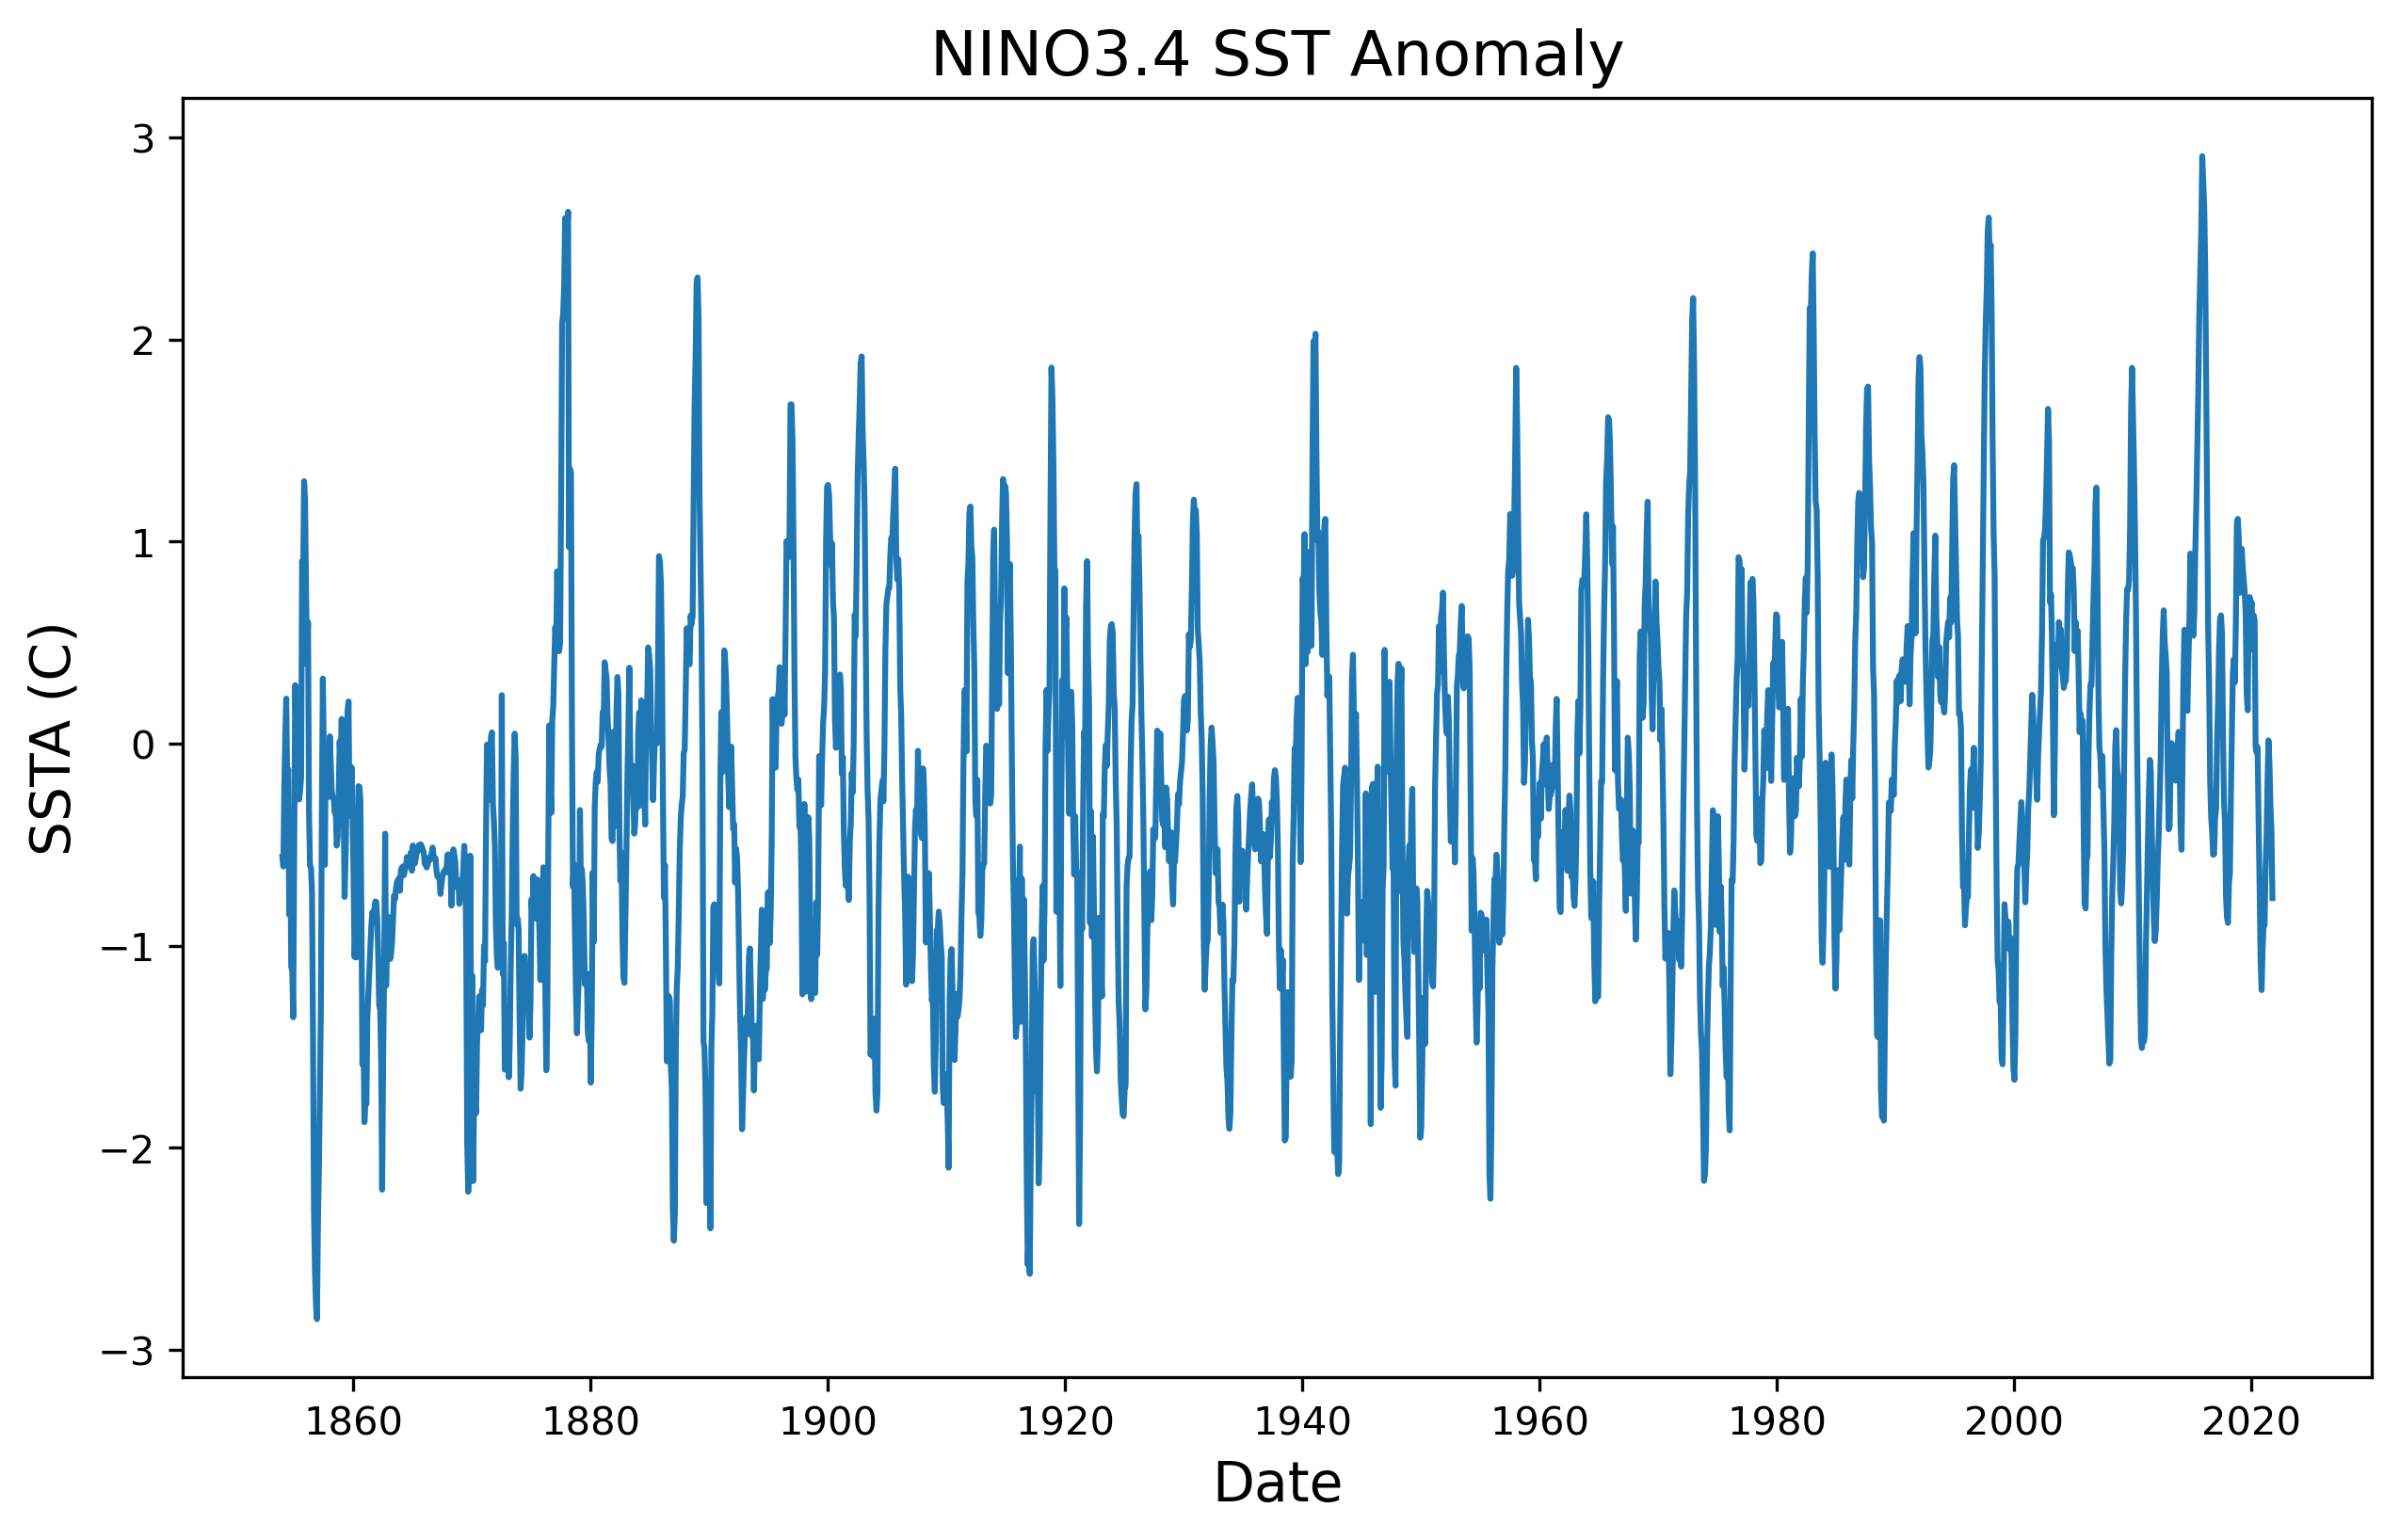

In [12]:
# create a new figure, set size and resolution (dpi)
plt.figure(figsize=(10, 6), dpi=300)    
# add data to the plot
plt.plot(n34_ssta.time,n34_ssta.sst)   
# Set plot parameters
plt.title('NINO3.4 SST Anomaly', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('SSTA (C)', fontsize=14)

Now that the seasonal cycle has been removed, it's much more obvious when there are large excursions from what is climatologically "normal" for that time of year. 

There are many definitions for El Nino and La Nina events. Here, let's use the one that NOAA uses in its operational ENSO forecasts:
https://www.nws.noaa.gov/ost/climate/STIP/ElNinoDef.htm

This definition states that El Nino is "a positive sea surface temperature departure from normal (for the 1971-2000 base period) in the Niño 3.4 region greater than or equal in magnitude to 0.5 degrees C (0.9 degrees Fahrenheit), averaged over three consecutive months." with La Nina being the same thing, but using a threshold of -0.5C. 

Since we want signals that persist over three consecutive months, we'll use the `rolling` method to isolate periods where the running 3-month average is above/below the threshold:

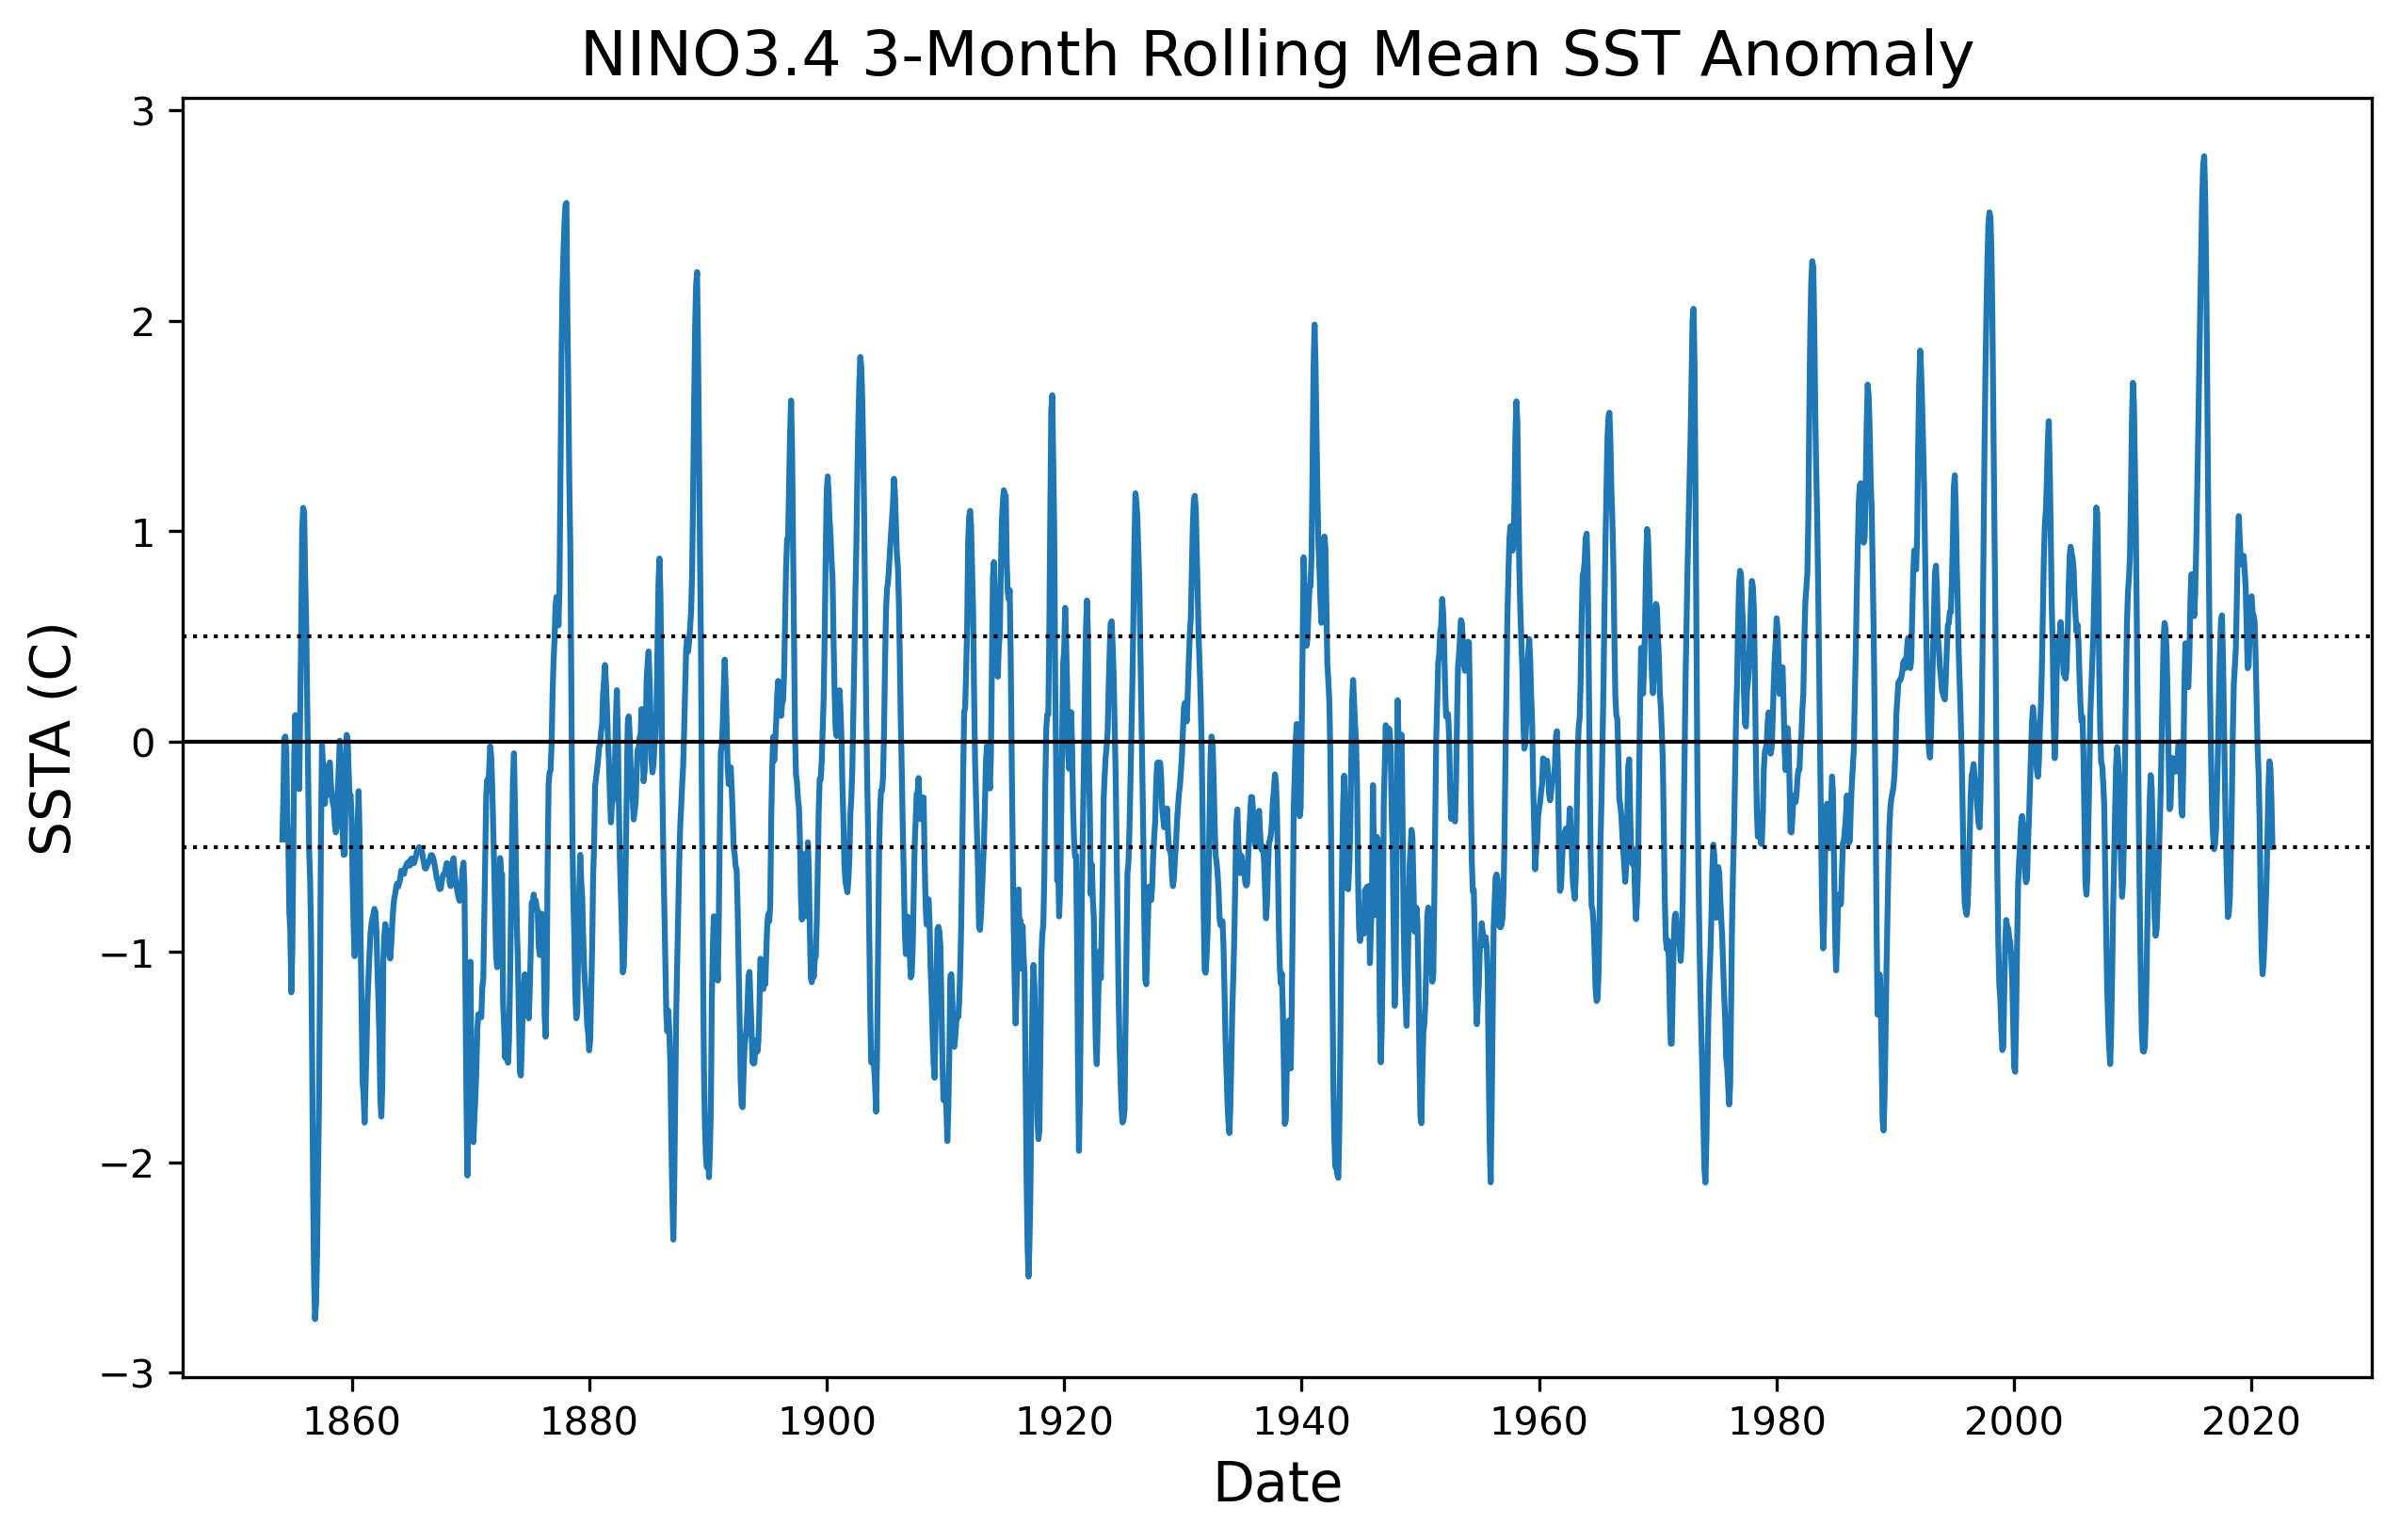

In [13]:
# Calculate 3-month rolling mean NINO3.4 SSTA
n34_ssta_3mth = n34_ssta.rolling(time=3).mean()

# create a new figure, set size and resolution (dpi)
plt.figure(figsize=(10, 6), dpi=300)    
# add data to the plot
plt.plot(n34_ssta_3mth.time,n34_ssta_3mth.sst)   
# Set plot parameters
plt.title('NINO3.4 3-Month Rolling Mean SST Anomaly', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('SSTA (C)', fontsize=14)
plt.axhline(0,color='black',lw=1)
plt.axhline(0.5,color='black',lw=1,linestyle="dotted")
plt.axhline(-0.5,color='black',lw=1,linestyle="dotted")

Another powerful data analysis technique is the use of thresholds for _compositing_. In other words: select all parts of a dataset which satisfy some criterion (in this case, exceeding the El Nino/La Nina SSTA threshold) and making an average over those periods.

The below code creates logical masks for the NINO 3.4 SSTA time series which are either:
- True when El Nino, False other times; or
- True when La Nina, False other times:

In [36]:
# Mask for El Nino
en_msk = (n34_ssta_3mth > 0.5)
# Mask for La Nina
ln_msk = (n34_ssta_3mth < -0.5)

Using these logical masks, and the knowledge that the full set of ERSST data has the same size time dimension as the NINO3.4 SSTA time series, we can then use this to construct a composite of the SST anomaly _patterns_ present during El Nino and La Nina events. 

First, we need to compute a new array, containing spatial fields of SST anomalies. We can do this using the same group by approach we applied to the NINO3.4 time series:

In [37]:
# Calculate base period climatology and remove it from the ERSST field
ersst_anom = ersst.groupby("time.month") - ersst.sel(time=slice('1971-01-01','2000-12-31')).groupby("time.month").mean("time")


Now we apply the logical masks to this new SST anomaly field, and average over time to create a composite map:

In [42]:
# Apply El Nino mask and extract the xarray DataArray
en_comp = ersst_anom.where(en_msk).mean("time")
encomp_arr = en_comp.to_array().squeeze()

# Apply La Nina mask and extract the xarray DataArray
ln_comp = ersst_anom.where(ln_msk).mean("time")
lncomp_arr = ln_comp.to_array().squeeze()

The final step is to plot this as a nicely formatted map! This can be accomplished using the functionality of cartopy.

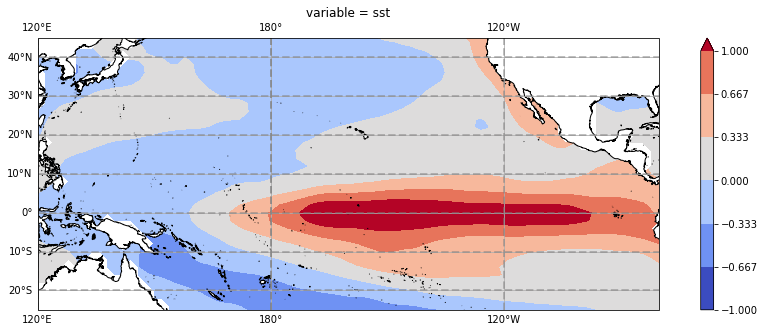

In [43]:
# Create an object containing the Plate-Carree map projection, centered at 180E
proj = ccrs.PlateCarree(central_longitude=180)
# Create a figure object
fig = plt.figure(figsize=(15, 5))
# Create an axis object using the specified projection
ax = plt.axes(projection=proj)
# Make a filled contour plot of the El Nino SSTA composite using the specified map projection
encomp_arr.plot.contourf(x='lon', y='lat',transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap='coolwarm')

# Set plot parameters
ax.gridlines()
ax.set_extent([120, 280, -25, 45], crs=ccrs.PlateCarree())
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='white')
ax.add_feature(coast_10m)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

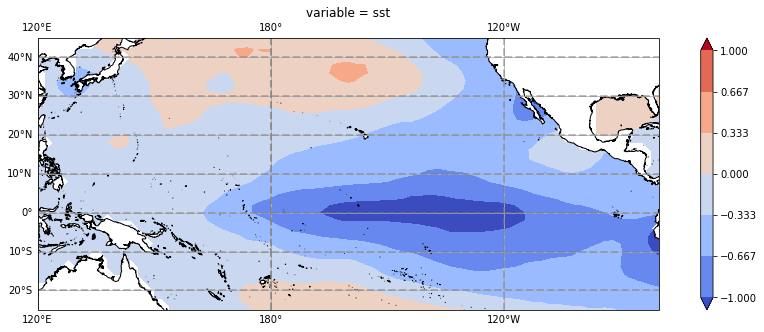

In [44]:
# Create an object containing the Plate-Carree map projection, centered at 180E
proj = ccrs.PlateCarree(central_longitude=180)
# Create a figure object
fig = plt.figure(figsize=(15, 5))
# Create an axis object using the specified projection
ax = plt.axes(projection=proj)
# Make a filled contour plot of the La Nina SSTA composite using the specified map projection
lncomp_arr.plot.contourf(x='lon', y='lat',transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap='coolwarm')

# Set plot parameters
ax.gridlines()
ax.set_extent([120, 280, -25, 45], crs=ccrs.PlateCarree())
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='white')
ax.add_feature(coast_10m)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

### **PART II: Marine Heat Waves**

The next example of SST-based data analysis is marine heat waves: these are events where SST is above a (typically very high) local threshold. 

Here we'll use the OISSTv2 data, since we'll need daily resolution. The OISSTv2 data are stored in many files, each containing information for a single year. The base directory where the information is located can be found here:

https://psl.noaa.gov/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.html

We are also only interested in data within the tropical Pacific - that means that we don't have to read in the entire file, only the subset of it within our region of interest.

All of these tasks can be accomplished by combining _spatial subsetting_ with a carefully constructed _for loop_.

First, let's specify some parameters appropriate for accessing the OISST files. Since we know that there will be one file per year, we can store the "base URL" (first part of the filename) and create a sequence of years of interest using the `range()` function:

In [112]:
# NOAA THREDDS server: base URL for all files 
base_url="https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/"

# Naming convention for files: "sst.day.mean.[year].v2.nc"
yrs=range(2017,2019)
print(yrs)

range(2017, 2019)


This combination of information now allows us to open any OISST file. To make things easier, let's work with the anomaly files; these are files which have already had the seasonal climatology subtracted out, so we don't have to do that step again.

As an example, the following will open the file for 1981:

In [113]:
test=xr.open_dataset("https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom."+str(yrs[0])+".v2.nc")
test

<xarray.Dataset>
Dimensions:  (time: 365, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    anom     (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    DODS_EXTRA.Unlimited_Dimension:  time

Now let's extend this to read in data over the entire range of years. 

The below code chunk will take a few minutes to run, since the data files we're working with are quite large. Run time was roughly 1 minute during initial testing of this notebook, for a time range of 2017-2019.

In [114]:
nepac_sst=[]     # Blank variable to store output data 

for y in yrs:
    print(y)
    
    # Open the dataset into an xarray object
    mysst=xr.open_dataset("https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom."+str(y)+".v2.nc")
    
    # Define logical mask to be true in the Northeast Pacific (30-50N, 180-240E)
    mask_lon = (mysst.lon >= 180) & (mysst.lon <= 240)
    mask_lat = (mysst.lat >= 30) & (mysst.lat <= 50)
    # Read in data 
    nepac_sst.append(mysst.where(mask_lon & mask_lat, drop=True).squeeze())
    

2017
2018


For purposes of demonstration, I have also gone through the process of reading in the full 1981-2021 period, and stored this in a "pickle" file. The commands used to do this were:

In [106]:
#with open('oisstv2_nepac.pickle','wb') as f:
#    pickle.dump(nepac_sst,f)

We can now easily restore this information without the need to go through the full for loop via THREDDS:

In [115]:
with open('oisstv2_nepac.pickle','rb') as f:
    nepac_sst=pickle.load(f)

Since we have appended each year's data to the initially blank output variable, the data returned is a list of xarray Datasets. We can convert this into a single Dataset containing time information for all years using `xr.concat`:

In [117]:
# Concatenate list of xarray Datasets into a single Dataset, along dimension "time"
nepac_fldts=xr.concat(nepac_sst,dim='time')
nepac_fldts

# Calculate a regionally averaged time series for the NE Pacific
nepac_ts=nepac_fldts.mean('lon').mean('lat')

Now let's try a new analysis: looking at the exceedance of the _daily_ SST anomaly over a given threshold. This is a standard approach used in marine heat wave studies, although the thresholds and persistence times used are not yet as "standardized" as those used in ENSO research.

There is a paper by Hobday et al. (2016) which proposes numerous marine heat wave definitions - let's use this one:
- Daily SST anomaly exceeding the 90th percentile (for 5 or more days)

If we were doing this for real, the 90th percentile value would be calculated using a long baseline (roughly 30 years or more), but we'll "pretend" for now using the 5-year time series above to shorten the data I/O time needed. To make the computation simpler, we'll also ignore the 5-day persistence requirement for now.

The method of calculating percentiles we will use is a numpy function called `percentile`, since xarray itself does not contain a native percentile function. In order to apply this percentile calculation to the xarray dataset, we can use an xarray method called `reduce`: this reduces the size of a dataset by applying a function you pass it as an argument.

The below code chunk will return the 90th percentile of the NE Pacific time series:

In [118]:
thr=nepac_ts.reduce(np.percentile,q=90)
print(thr)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    anom     float64 0.6475


Now we can use the same logical masking method to identify all places within the NE Pacific time series which exceed that threshold:

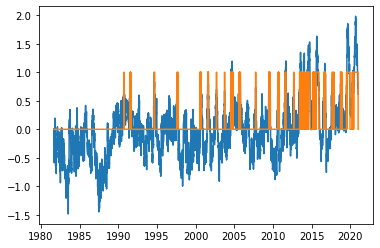

In [119]:
# Mask for MHW
mhw_msk = (nepac_ts > thr)
mhw_msk

# Make a quick plot to see if the masking worked
plt.plot(nepac_ts.time,nepac_ts.anom)
plt.plot(nepac_ts.time,mhw_msk.to_array().squeeze())

As for the ENSO example, this mask can now be used to composite over all marine heat wave events:

In [120]:
# Apply MHW mask and extract the xarray DataArray
mhw_comp = nepac_fldts.where(mhw_msk).mean("time")
mhwcomp_arr = mhw_comp.to_array().squeeze()

Finally, we make another cartopy plot to display the results!

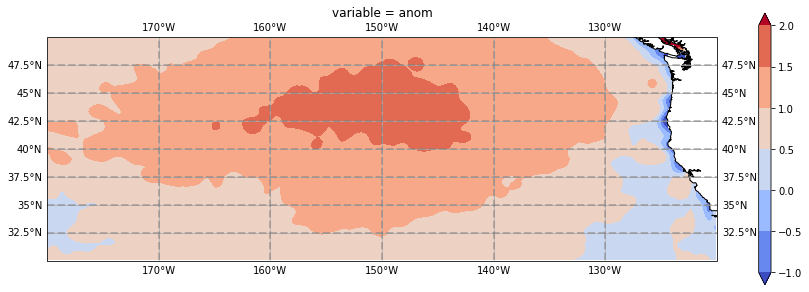

In [121]:
# Create an object containing the Plate-Carree map projection, centered at 180E
proj = ccrs.PlateCarree(central_longitude=180)
# Create a figure object
fig = plt.figure(figsize=(15, 5))
# Create an axis object using the specified projection
ax = plt.axes(projection=proj)
# Make a filled contour plot of the La Nina SSTA composite using the specified map projection
mhwcomp_arr.plot.contourf(x='lon', y='lat',transform=ccrs.PlateCarree(),vmin=-1,vmax=2,cmap='coolwarm')

# Set plot parameters
ax.gridlines()
ax.set_extent([180, 240, 30, 50], crs=ccrs.PlateCarree())
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='white')
ax.add_feature(coast_10m)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

#### Examining Properties of Marine Heat Waves

Now let's take things slightly further. Often, we care not only about the _composite_ patterns across all heat wave events, but about individual properties of those events. Some relevant examples:
- Temporal persistence: how long does a heat wave last?
- Maximum temperature: how hot does it get?
- Cumulative thermal stress: what is the "effective" combination of heat and time during the heat wave event?

To accomplish this, we must be able to identify individual marine heat wave events within a time series, and perform appropriate operations on the portion of the time series within those events. 

The `scipy` package in Python has some excellent built-in tools to identify "events" within a time series: here we'll use the `scipy.ndimage.label` functionality. This treats the input time series as an "image", which can be n-dimensional (hence the name), and "labels" parts of the input data which are considered to be connected to one another in some way. There are various options for specifying that connectivity, but here we'll just use the simplest one: a data point is connected to the preceding point if it is equal to the value at that preceding point.

Using the previously defined mask for marine heat waves, `mhw_msk`, this command identifies MHW events:

In [196]:
# Determine number of events
events, n_events = ndimage.label(mhw_msk.to_array())
n_events

Note that we had to convert the `mhw_msk` object to a "DataArray" first using the `to_array()` method in order for this to work correctly.

Using this set of events, we can now do things like collect all the temperature data within the events. Before we start doing that, though, let's specify an output variable to hold the information: the Python "dictionary" data type is useful here since it will allow us to store many different aspects of MHW behavior.

In [244]:
# Define empty variable to put MHW data into (type "dictionary")
mhw = {}

# Specify start, end time variables within the dataset
mhw['time_start'] = [] 
mhw['time_end'] = [] 
mhw['duration'] = [] 
mhw['dates'] = []

# Specify variables to hold MHW parameters
mhw['temp_mhw'] = []
mhw['time_peak'] = []
mhw['intensity_max'] = []
mhw['intensity_mean'] = []
mhw['intensity_cumulative'] = []

Now we can go ahead and compile the relevant information into `mhw`. First, let's simply identify and store the starting and ending times associated with each MHW event, with the requirement that there is some minimum duration it must exceed in order to be considered. Here I'll use the 5-day threshold suggested by Hobday et al. (2016):

In [245]:
# Find all MHWs, collect temperature data within them into a list
minDuration=5    # set some minimum duration for the MHWs in order to count them

# Loop over set of all events
for ev in range(1,n_events+1):
    # Grab the part of the time series within the event, figure out how long it is
    event_duration = (events == ev).sum()
    # Figure out whether the event is long enough to count
    if event_duration < minDuration:
        continue
    #print('Marine heat wave length = ' + str(event_duration) + ' days')
    # If event is long enough, add data to an array
    mhw['time_start'].append(nepac_ts.time[np.where(events == ev)[1][0]])
    mhw['time_end'].append(nepac_ts.time[np.where(events == ev)[1][-1]])
    mhw['duration'].append(event_duration)

#print(mhw['time_start'][0])
#print(mhw['time_start'])

# Add number of events to MHW dictionary
mhw['n_events'] = len(mhw['time_start'])

Next, we can apply this time information to extract specific portions of the temperature time series. 

In [246]:
for ev in range(mhw['n_events']):
    # Get starting, ending point within the time series for the MHW event in question
    tt_start = np.where(nepac_ts.time==mhw['time_start'][ev])[0][0]
    tt_end = np.where(nepac_ts.time==mhw['time_end'][ev])[0][0]
    
    # Extract time series information
    temp_mhw = nepac_ts.anom[tt_start:tt_end+1]
    mhw['temp_mhw'].append(temp_mhw)
    mhw['dates'].append(nepac_ts.time[tt_start:tt_end+1])
    
    # Get peak value = date of maximum temp during MHW
    tt_peak = temp_mhw.argmax('time')
    
    # Time/date of maximum value    
    mhw['time_peak'].append(mhw['time_start'][ev] + tt_peak)
    
    # MHW Duration
    mhw['duration'].append(len(temp_mhw))
    
    # MHW intensity 
    mhw['intensity_max'].append(temp_mhw[tt_peak])
    mhw['intensity_mean'].append(temp_mhw.mean())
    mhw['intensity_cumulative'].append(temp_mhw.sum())
  

Let's take a look at some of these events now! First, display some summary information for the largest MHW event.

In [248]:
ev = np.argmax(mhw['intensity_max']) # Find largest event
dates = mhw['dates'][ev].values
print('Maximum intensity:', mhw['intensity_max'][ev].values, 'deg. C')
print('Average intensity:', mhw['intensity_mean'][ev].values, 'deg. C')
print('Cumulative intensity:', mhw['intensity_cumulative'][ev].values, 'deg. C-days')
print('Duration:', mhw['duration'][ev], 'days')
print('Start date:', mhw['time_start'][ev].values)
print('End date:', mhw['time_end'][ev].values)

Maximum intensity: 1.9806232 deg. C
Average intensity: 1.3047467 deg. C
Cumulative intensity: 273.99683 deg. C-days
Duration: 210 days
Start date: 2020-06-01T00:00:00.000000000
End date: 2020-12-27T00:00:00.000000000


#### Plot results

Finally, let's make some plots! Here is a way to plot a filled-in time series illustrating the location of the largest MHW event:

Text(0.5, 1.0, 'SST (black), threshold (green), detected MHW events (shading)')

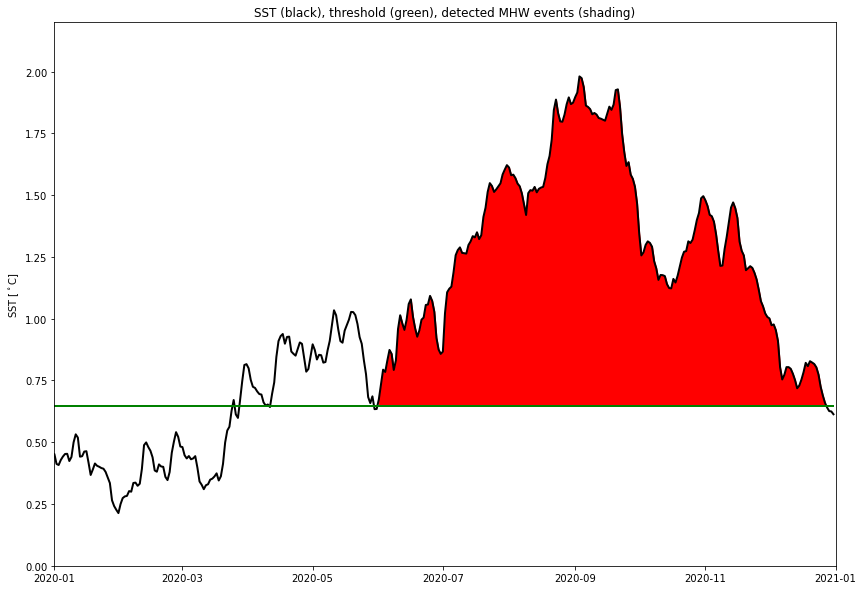

In [290]:
plt.figure(figsize=(14,10))
plt.plot(nepac_ts.time, nepac_ts.anom, 'k-', linewidth=2)
plt.plot(nepac_ts.time, np.repeat(thr.anom.values,len(nepac_ts.time),axis=0), 'g-', linewidth=2)
plt.xlim(('2020-01-01','2021-01-01'))
plt.ylim(0,2.2)

# Find indices for MHW of interest and shade accordingly
t1 = np.where(nepac_ts.time==mhw['time_start'][ev])[0][0]
t2 = np.where(nepac_ts.time==mhw['time_end'][ev])[0][0]
plt.fill_between(nepac_ts.time[t1:t2+1].values, nepac_ts.anom[t1:t2+1], np.repeat(thr.anom.values,len(nepac_ts.time[t1:t2+1]),axis=0), color='r')

# Set plot axis labels etc
plt.ylabel(r'SST [$^\circ$C]')
plt.title('SST (black), threshold (green), detected MHW events (shading)')

We can also summarize the statistics of MHW events using probability distribution functions.

Text(0.5, 1.0, 'PDF of MHW mean intensity values')

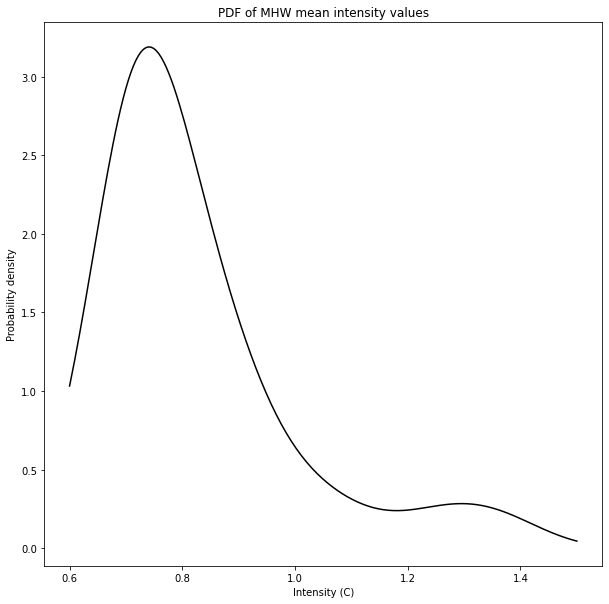

In [309]:
# Concatenate mean intensity information into a DataArray
mhw_mnint = xr.concat(mhw['intensity_mean'],dim='event')

# Perform kernel density estimation on mean intensity values
kde = stats.gaussian_kde(mhw_mnint.values)

# Display as PDF
fig = plt.figure(figsize=(10,10))
x_eval = np.linspace(0.6, 1.5, num=200)
plt.plot(x_eval, kde(x_eval), 'k-')
plt.xlabel('Intensity (C)')
plt.ylabel('Probability density')
plt.title('PDF of MHW mean intensity values')

### References

Hobday, A.J., Alexander, L.V., Perkins, S.E., Smale, D.A., Straub, S.C., Oliver, E.C., Benthuysen, J.A., Burrows, M.T., Donat, M.G., Feng, M. and Holbrook, N.J., 2016. A hierarchical approach to defining marine heatwaves. Progress in Oceanography, 141, pp.227-238.

Hobday, A.J., E.C.J. Oliver, A. Sen Gupta, J.A. Benthuysen, M.T. Burrows, M.G. Donat, N.J. Holbrook, P.J. Moore, M.S. Thomsen, T. Wernberg, and D.A. Smale. 2018. Categorizing and naming marine heatwaves. Oceanography 31(2):162–173

In [305]:
mhw_mnint.values

array([0.66049844, 0.7006545 , 0.73312277, 0.78271794, 0.7326219 ,
       0.7656609 , 0.7094256 , 0.7065791 , 0.7847113 , 0.91748965,
       0.7945168 , 0.83152086, 0.69276804, 0.72367865, 0.6971196 ,
       0.68891126, 0.73138785, 0.68926764, 0.8972738 , 0.68927187,
       0.6807808 , 1.0172012 , 0.75448465, 1.0096056 , 0.8552371 ,
       0.8842254 , 1.2365957 , 0.75361884, 0.7877683 , 1.1056448 ,
       0.72651714, 0.76068974, 0.9106835 , 0.7205085 , 0.73019475,
       0.8217044 , 0.85645163, 0.72017723, 1.3799312 , 0.7213551 ,
       0.881151  , 1.3047467 ], dtype=float32)